In [1]:
%%capture 

# Important header information
#amrwindfedir = '/projects/wind_uq/lcheung/amrwind-frontend'         # official version
#amrwindfedir = '/projects/hfm/lcheung/amrwind-frontend'
amrwindfedir = '/projects/hfm/lcheung/amrwind-frontend/'
import sys, os
sys.path.insert(1, amrwindfedir)
sys.path.insert(1, '../utilities')

# Load the libraries
import matplotlib.pyplot as plt
import amrwind_frontend  as amrwind
import numpy             as np
from matplotlib import cm
import SOWFAdata as sowfa
import postproamrwindsample as ppsample

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
# WRF Forcing data
# SOWFA profile directories
SOWFAdir  = '../SOWFA-WRFforcing/winter-unstable/drivingData/'
Tfile     = SOWFAdir+'/givenSourceT'
Ufile     = SOWFAdir+'/givenSourceU_component_rotated'
tfluxfile = SOWFAdir+'/surfaceTemperatureFluxTable'

# Load the SOWFA data
zT                   = sowfa.readsection(Tfile, 'sourceHeightsTemperature')
sowfatime, sowfatemp = sowfa.readsection(Tfile, 'sourceTableTemperature',
                                         splitfirstcol=True)

zMom                 = sowfa.readsection(Ufile, 'sourceHeightsMomentum')

t1, sowfa_momu       = sowfa.readsection(Ufile, 'sourceTableMomentumX',
                                         splitfirstcol=True)
t2, sowfa_momv       = sowfa.readsection(Ufile, 'sourceTableMomentumY',
                                         splitfirstcol=True)

t3, sowfa_tflux      = sowfa.readplainfile(tfluxfile, splitfirstcol=True)

print("Loaded SOWFA profiles")

Loaded SOWFA profiles


In [3]:
itime=4
sowfatime[itime]

1200.0

# Setup
## The input file

In [4]:
# Print the input file
inputfile='ATLVINEYARD_big2.inp'
%cat ATLVINEYARD_big2.inp

# --- Simulation time control parameters ---
time.stop_time                           = 43200.0             # Max (simulated) time to evolve [s]
time.max_step                            = -172800              
time.fixed_dt                            = 0.20                # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.cfl                                 = 0.95                # CFL factor
time.checkpoint_interval                 = 20000               
incflo.physics                           = ABL                 # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84        
TKE.source_terms                         = KsgsM84Src          
nodal_proj.mg_rtol

## Plot the domain

This is what the case looks like.

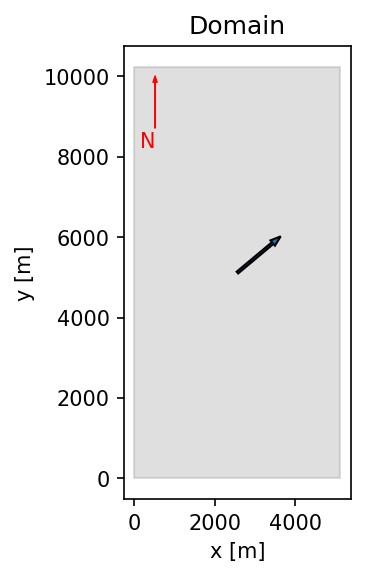

In [5]:
# Start the amrwind_frontend app 
tutorial2 = amrwind.MyApp.init_nogui()

# Load the input into the app
tutorial2.loadAMRWindInput(inputfile)

fig, ax = plt.subplots(figsize=(4,4), facecolor='w', dpi=150)

# Set any additional items to plot
tutorial2.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #['p_hub']
tutorial2.plotDomain(ax=ax)

# Postprocessing

In [6]:
 # Set your run directory here
casedir = './'

# Average between 15,000 sec to 20,000 sec
#avgtimes = [950, 1050]

## Plot the sample planes

In [7]:
tutorial2.Samplepostpro_loadnetcdffile(casedir+'/post_processing/sampling00000.nc')

Loading .//post_processing/sampling00000.nc


In [10]:
sampletime        = ppsample.getVar(tutorial2.sample_ncdat, 'time')
plottindex        = [1080, 1440,  1800, 2160]

Uhoriz = {}
for tindex in plottindex:
    print(sampletime[tindex]/3600)
    xU,yU,zU, s1, s2, vx = ppsample.getPlaneSampleAtTime(tutorial2.sample_ncdat, 'p_hub', 'velocityx', tindex, 1)
    xU,yU,zU, s1, s2, vy = ppsample.getPlaneSampleAtTime(tutorial2.sample_ncdat, 'p_hub', 'velocityy', tindex, 1)
    Uhoriz[tindex] = np.sqrt(vx**2 + vy**2)

6.000000000012088
8.000000000019364
10.00000000001031
11.999999999981206


In [15]:
for tindex in plottindex:
    print(sampletime[tindex]/3600, np.mean(Uhoriz[tindex]))

6.000000000012088 8.735951740692553
8.000000000019364 7.2881282929097315
10.00000000001031 7.169887263662128
11.999999999981206 9.555197608391593


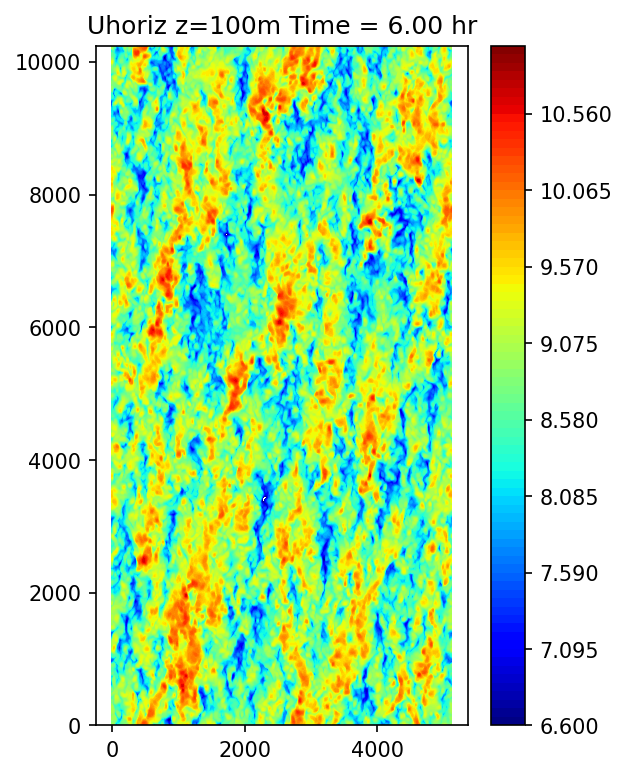

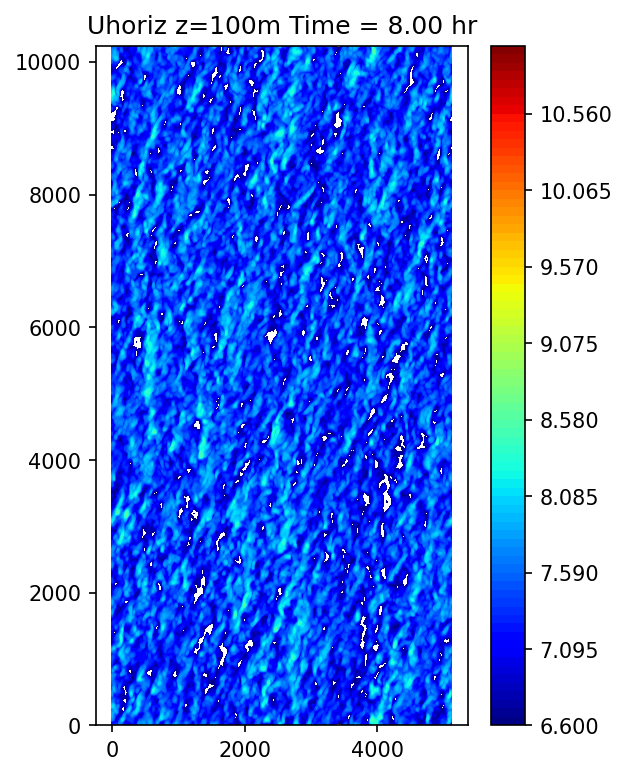

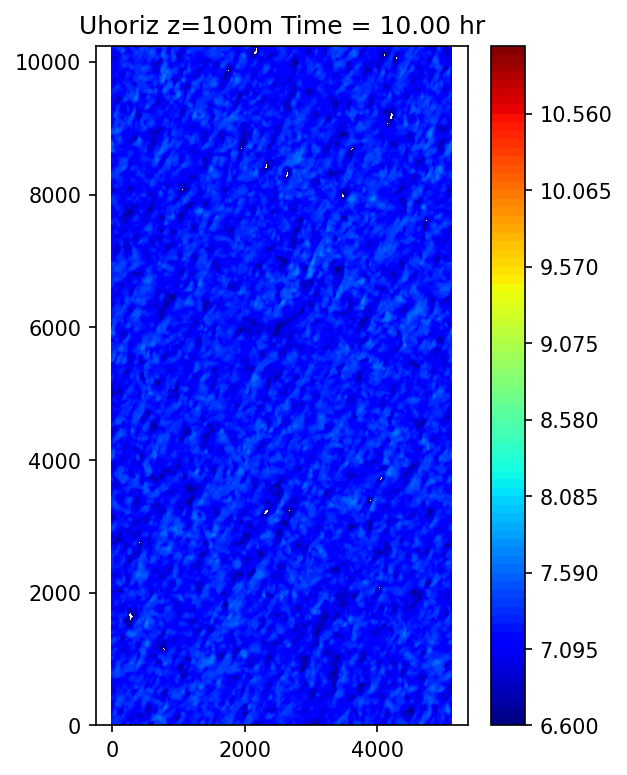

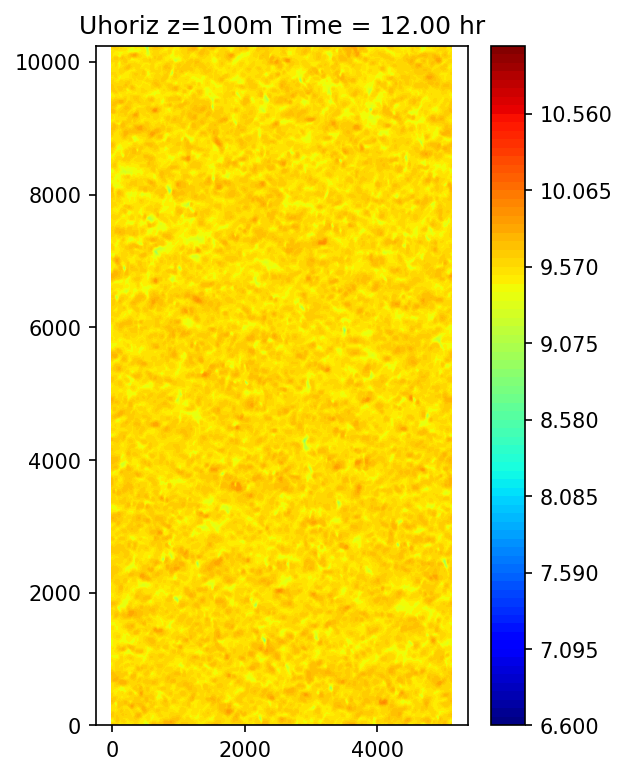

In [23]:
for tindex in plottindex:
    plt.subplots(figsize=(4,6), facecolor='w', dpi=150)
    plt.contourf(xU, yU, Uhoriz[tindex], np.linspace(6.6, 11, 81), cmap=cm.jet)
    plt.axis('equal')
    plt.title('Uhoriz z=100m Time = %0.2f hr'%(sampletime[tindex]/3600))
    plt.colorbar()

## Plot the temperature field

In [16]:
plottindex        = [1080, 1440,  1800, 2160]

Tfield = {}
for tindex in plottindex:
    print(sampletime[tindex]/3600)
    xTemp,yTemp,zTemp, s1, s2, T = ppsample.getPlaneSampleAtTime(tutorial2.sample_ncdat, 'xbc', 'temperature', tindex, 0)
    Tfield[tindex] = T

6.000000000012088
8.000000000019364
10.00000000001031
11.999999999981206


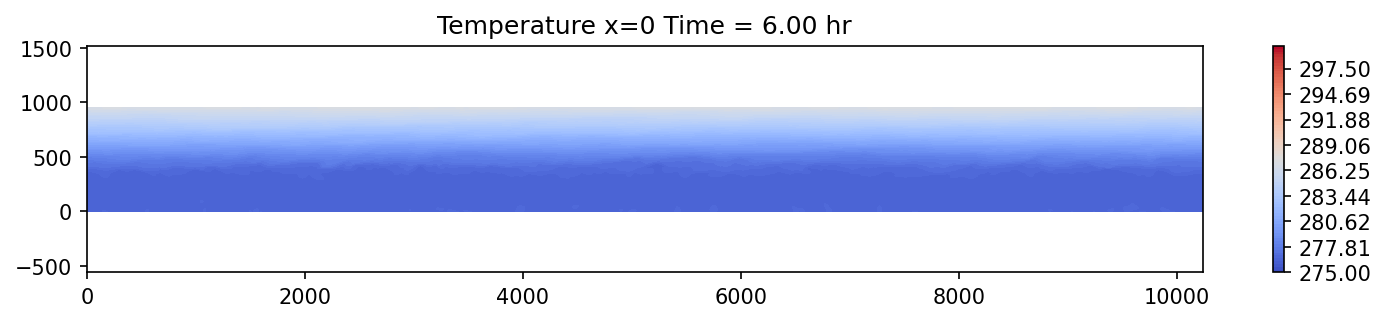

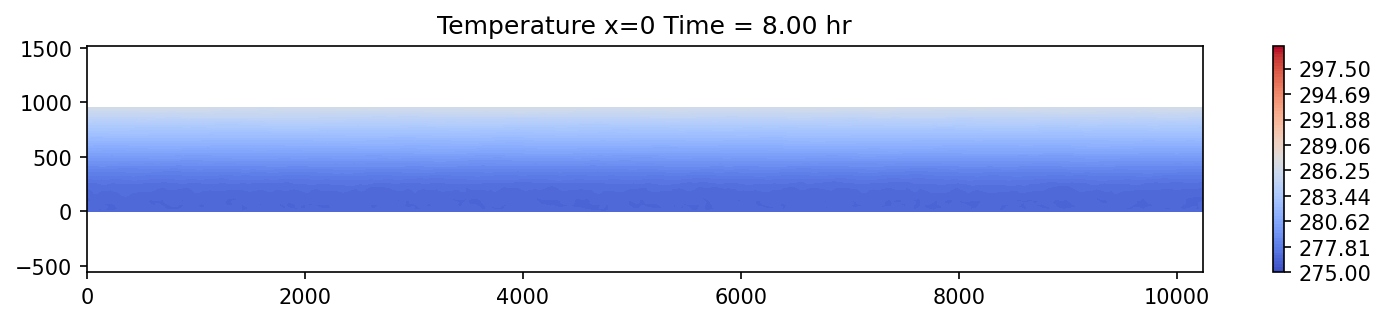

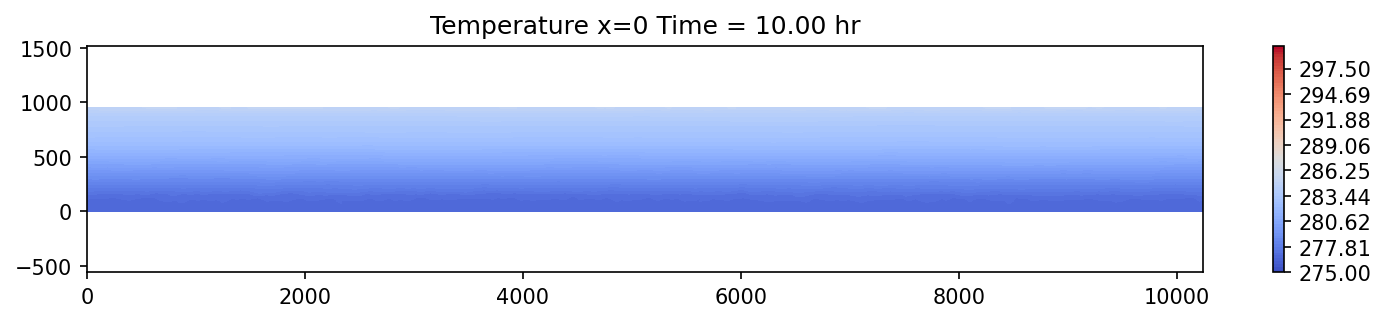

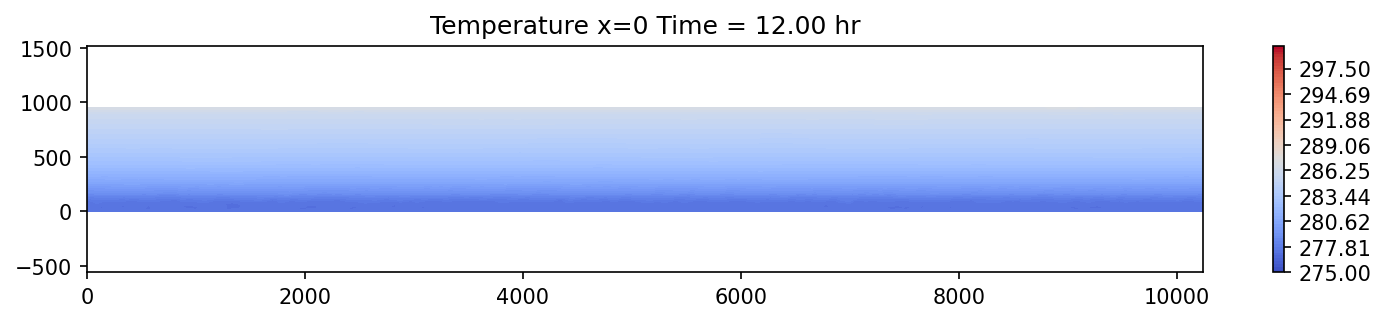

In [20]:
for tindex in plottindex:
    plt.subplots(figsize=(12,2), facecolor='w', dpi=150)
    plt.contourf(yTemp, zTemp, Tfield[tindex], np.linspace(275, 300, 81), cmap=cm.coolwarm)
    plt.axis('equal')
    plt.title('Temperature x=0 Time = %0.2f hr'%(sampletime[tindex]/3600))
    plt.colorbar()

## Plot the ABL statistics

In [18]:
tutorial2.ABLpostpro_loadnetcdffile(casedir+'/post_processing/abl_statistics00000.nc')
timevec=[48, 72, 96, 108, 144]

Loading .//post_processing/abl_statistics00000.nc
Time range: 0.250000 to 43200.000000
Done.


In [19]:
# First, let's look at the hub-height averaged statistics
#tutorial2.ABLpostpro_printreport(avgt=avgtimes, avgz=plotheights)

### Plot scalar statistics

ustar


(0.0, 0.5)

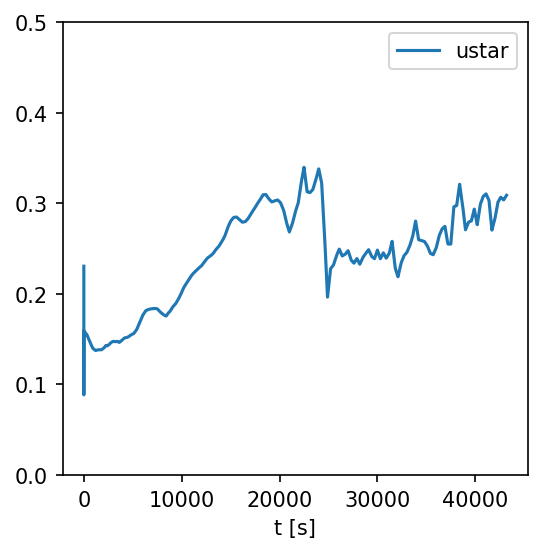

In [20]:
fig, ax = plt.subplots(figsize=(4,4), facecolor='w', dpi=150)
ustar=tutorial2.ABLpostpro_plotscalars(ax=ax, plotvars=['ustar'])
ax.set_ylim([0, 0.5])

### Plot profile statistics

Time = 14400.0
Loading u
Loading v
Time = 21600.0
Loading u
Loading v
Time = 28800.0
Loading u
Loading v
Time = 32400.0
Loading u
Loading v
Time = 43200.0
Loading u
Loading v


Text(0.5, 0.98, 'Horizontal velocity')

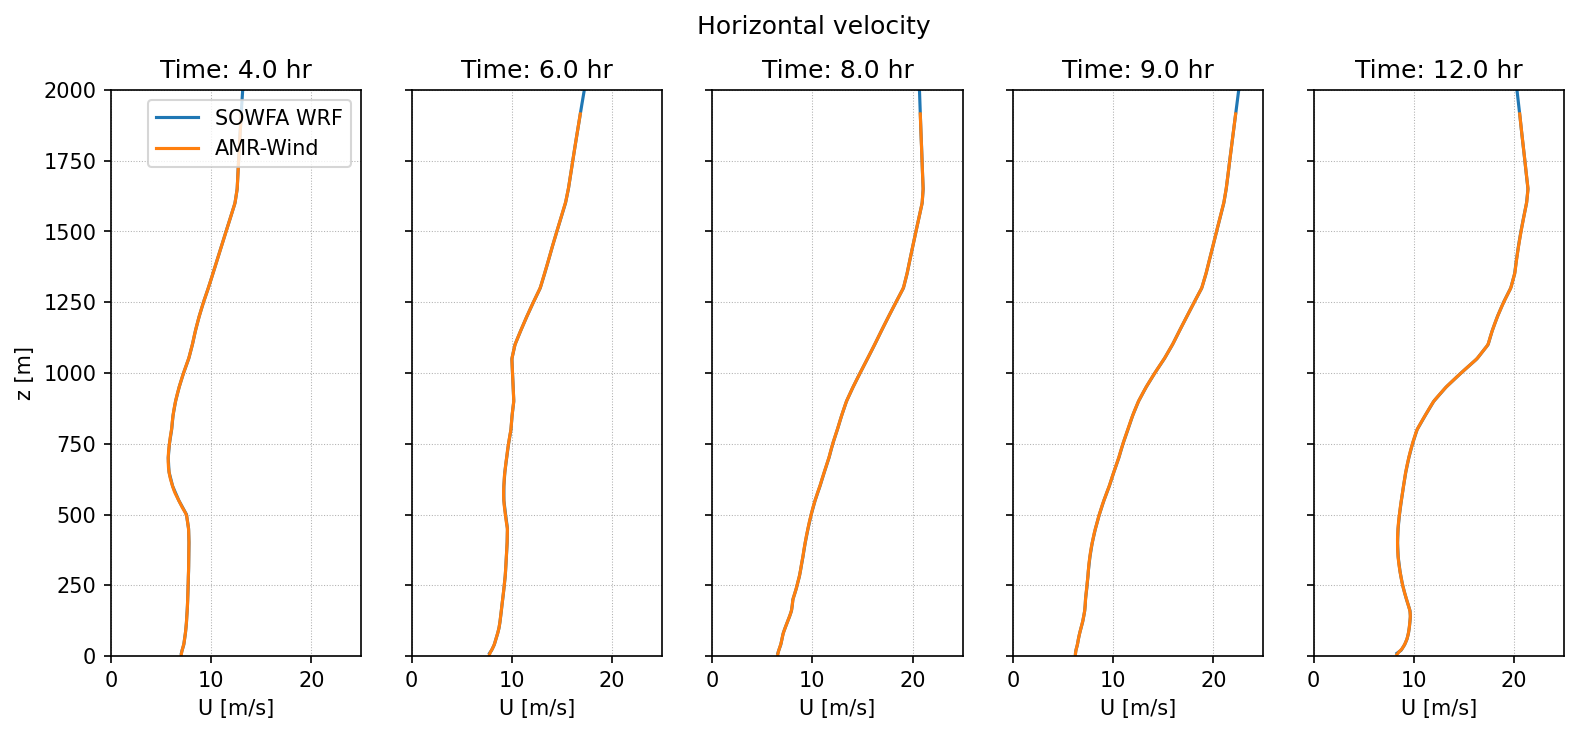

In [21]:
# Plot velocity
fig, axs = plt.subplots(1,len(timevec),figsize=(2.5*len(timevec),5), facecolor='w', dpi=150, sharey=True)

for it, time in enumerate(timevec):
    ax=axs[it]
    print('Time = %0.1f'%sowfatime[time])
    SOWFA_Uhoriz = np.sqrt(sowfa_momu[time,:]**2 + sowfa_momv[time,:]**2)
    dat=tutorial2.ABLpostpro_plotprofiles(ax=ax, plotvars=['Uhoriz'], 
                                          avgt=[sowfatime[time]-5, sowfatime[time]+5], doplot=False)
    ax.plot(SOWFA_Uhoriz, zMom, label='SOWFA WRF')
    ax.plot(dat['Uhoriz']['data'], dat['Uhoriz']['z'], label='AMR-Wind')
    ax.set_xlim([0, 25])
    ax.set_xlabel('U [m/s]')
    ax.grid(linestyle=':', linewidth=0.5)
    ax.set_ylim([0,2000])
    ax.set_title('Time: %0.1f hr'%(sowfatime[time]/3600.0))
    
axs[0].legend()
axs[0].set_ylabel('z [m]')
plt.suptitle('Horizontal velocity')

Time = 14400.0
Loading theta
Time = 21600.0
Loading theta
Time = 28800.0
Loading theta
Time = 32400.0
Loading theta
Time = 43200.0
Loading theta


Text(0.5, 0.98, 'Temperature')

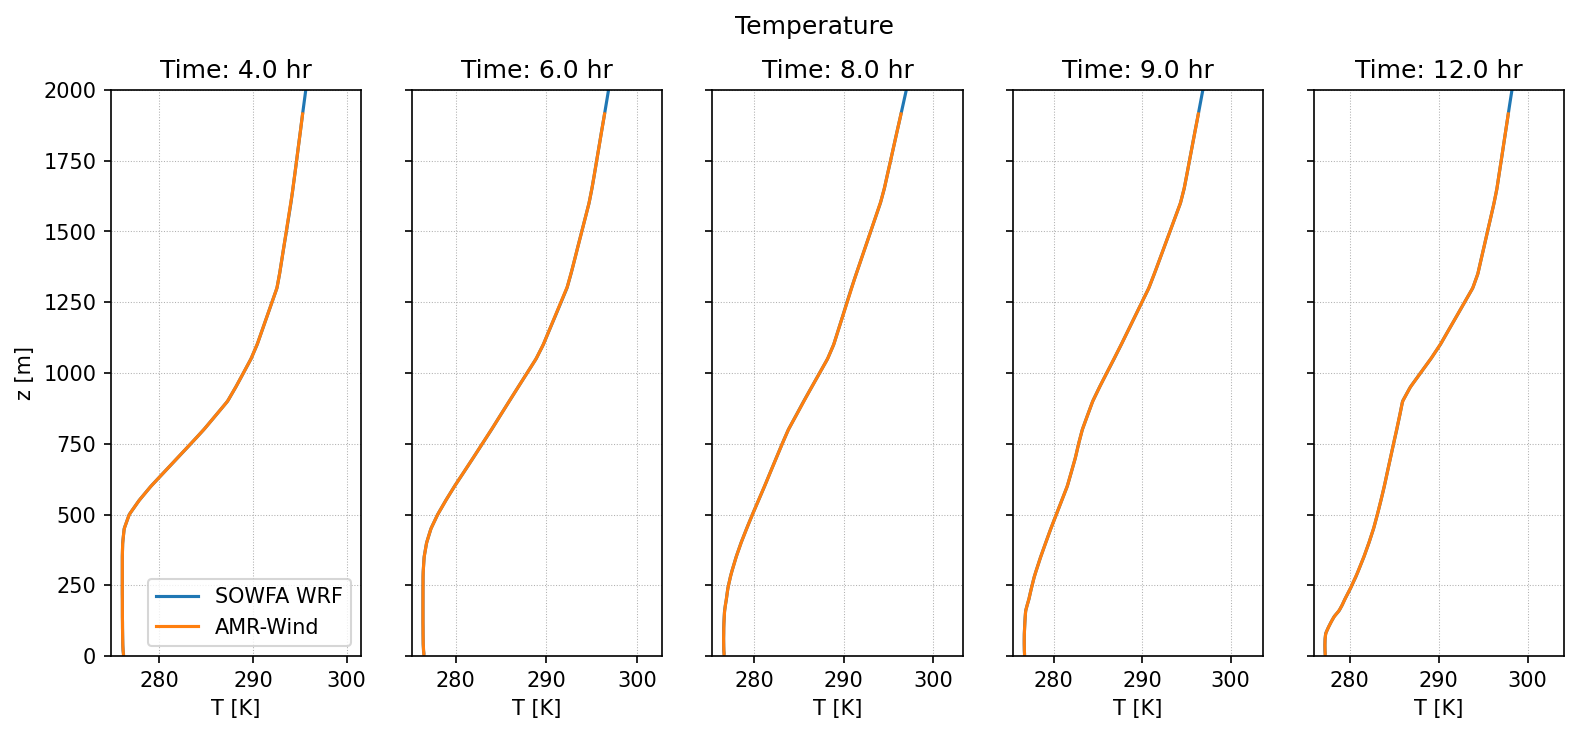

In [22]:
# Plot temperature
#timevec=[6,12,15]
fig, axs = plt.subplots(1,len(timevec),figsize=(2.5*len(timevec),5), facecolor='w', dpi=150, sharey=True)

for it, time in enumerate(timevec):
    ax=axs[it]
    print('Time = %0.1f'%sowfatime[time])
    dat=tutorial2.ABLpostpro_plotprofiles(ax=ax, plotvars=['Temperature'], 
                                          avgt=[sowfatime[time]-5, sowfatime[time]+5], doplot=False)
    ax.plot(sowfatemp[time,:], zT, label='SOWFA WRF')
    ax.plot(dat['T']['data'], dat['T']['z'], label='AMR-Wind')
    #ax.set_xlim([0, 15])
    ax.set_xlabel('T [K]')
    ax.grid(linestyle=':', linewidth=0.5)
    ax.set_ylim([0,2000])
    ax.set_title('Time: %0.1f hr'%(sowfatime[time]/3600.0))
    
axs[0].legend()
axs[0].set_ylabel('z [m]')
plt.suptitle('Temperature')

Time = 14400.0
Loading u
Loading v
Loading u'u'_r
Loading v'v'_r
Time = 21600.0
Loading u
Loading v
Loading u'u'_r
Loading v'v'_r
Time = 28800.0
Loading u
Loading v
Loading u'u'_r
Loading v'v'_r
Time = 32400.0
Loading u
Loading v
Loading u'u'_r
Loading v'v'_r
Time = 43200.0
Loading u
Loading v
Loading u'u'_r
Loading v'v'_r


Text(0.5, 0.98, 'Horizontal TI')

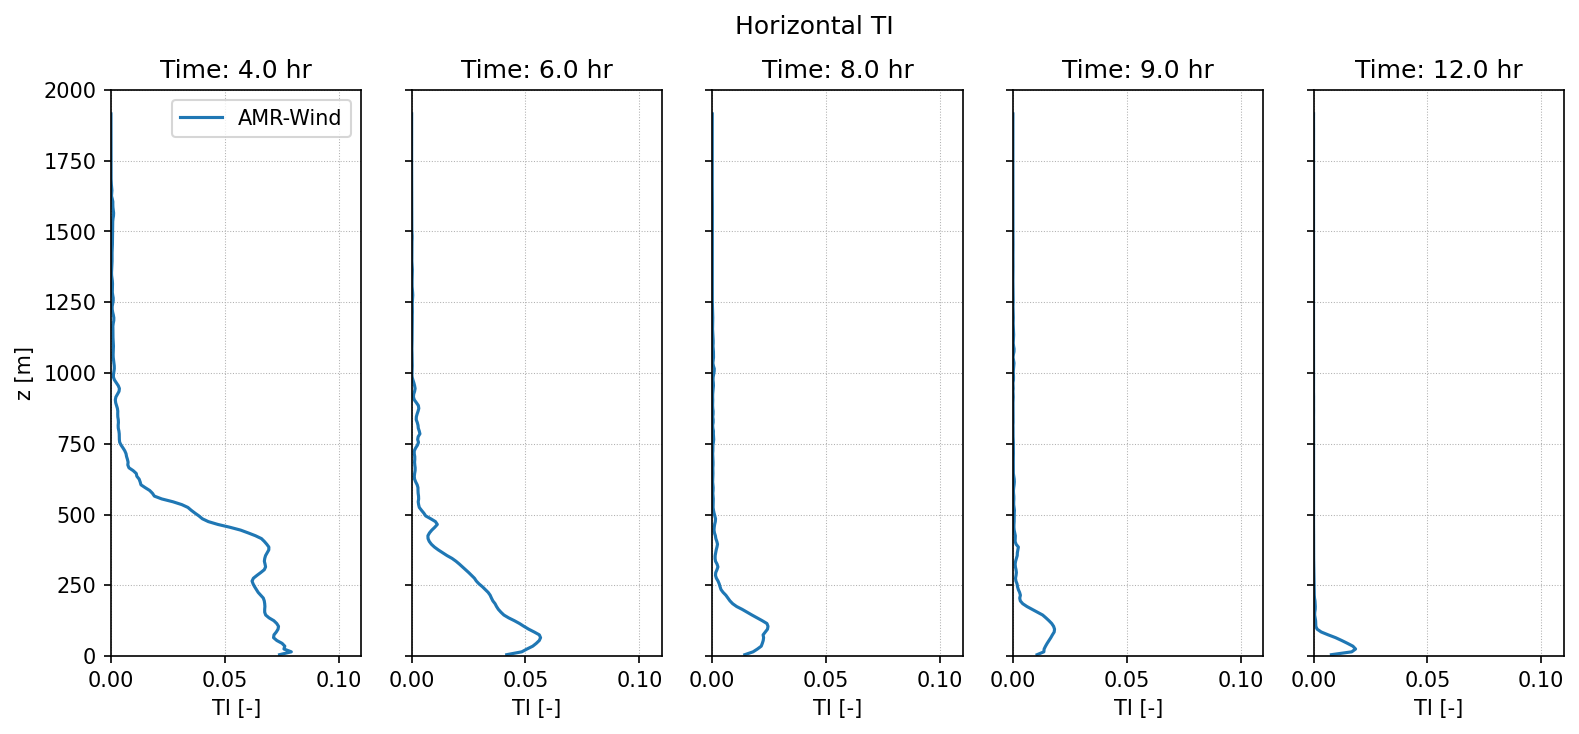

In [23]:
# Plot TI
#timevec=[6,12,15]
fig, axs = plt.subplots(1,len(timevec),figsize=(2.5*len(timevec),5), facecolor='w', dpi=150, sharey=True)

for it, time in enumerate(timevec):
    ax=axs[it]
    print('Time = %0.1f'%sowfatime[time])
    dat=tutorial2.ABLpostpro_plotprofiles(ax=ax, plotvars=['TI_horiz'], 
                                          avgt=[sowfatime[time]-5, sowfatime[time]+5], doplot=False)
    ax.plot(dat['TI_horiz']['data'], dat['TI_horiz']['z'], label='AMR-Wind')
    ax.set_xlim([0, 0.11])
    ax.set_xlabel('TI [-]')
    ax.grid(linestyle=':', linewidth=0.5)
    ax.set_ylim([0,2000])
    ax.set_title('Time: %0.1f hr'%(sowfatime[time]/3600.0))
    
axs[0].legend()
axs[0].set_ylabel('z [m]')
plt.suptitle('Horizontal TI')

Time = 14400.0
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r
Time = 21600.0
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r
Time = 28800.0
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r
Time = 32400.0
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r
Time = 43200.0
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r


Text(0.5, 0.98, 'Horizontal TKE')

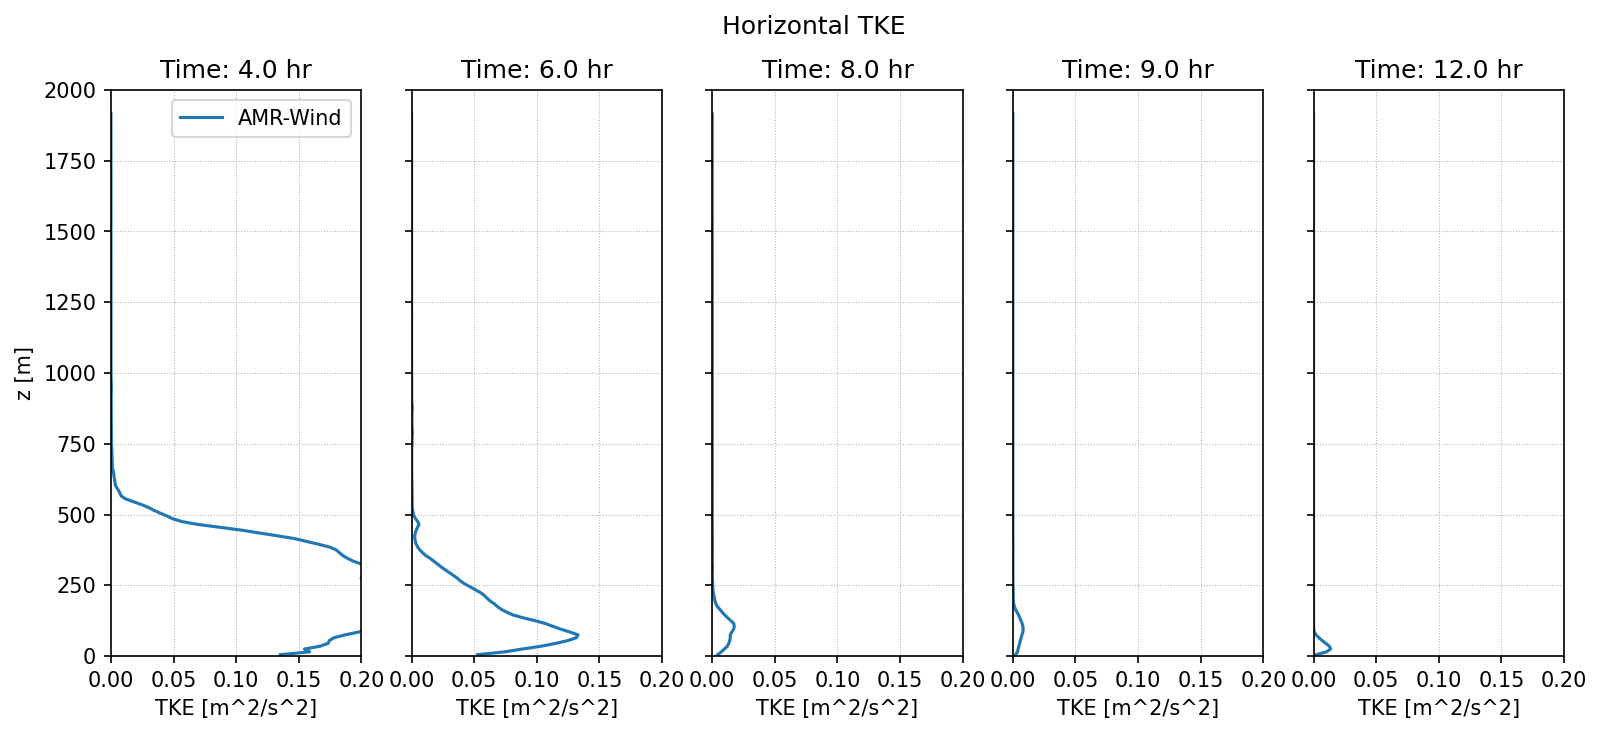

In [26]:
# Plot TKE
#timevec=[6,12,15]
fig, axs = plt.subplots(1,len(timevec),figsize=(2.5*len(timevec),5), facecolor='w', dpi=150, sharey=True)

for it, time in enumerate(timevec):
    ax=axs[it]
    print('Time = %0.1f'%sowfatime[time])
    dat=tutorial2.ABLpostpro_plotprofiles(ax=ax, plotvars=['TKE'], 
                                          avgt=[sowfatime[time]-5, sowfatime[time]+5], doplot=False)
    ax.plot(dat['TKE']['data'], dat['TKE']['z'], label='AMR-Wind')
    ax.set_xlim([0, 0.2])
    ax.set_xlabel('TKE [m^2/s^2]')
    ax.grid(linestyle=':', linewidth=0.5)
    ax.set_ylim([0,2000])
    ax.set_title('Time: %0.1f hr'%(sowfatime[time]/3600.0))
    
axs[0].legend()
axs[0].set_ylabel('z [m]')
plt.suptitle('Horizontal TKE')

In [25]:
"""
# Plot Reynolds Stresses
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
REstress=tutorial2.ABLpostpro_plotprofiles(ax=ax, plotvars=['ReStresses'], avgt=avgtimes)

ax.plot(nalustressprof[:,1], nalustressprof[:,0], '--', label='Nalu-Wind uu')
ax.plot(nalustressprof[:,2], nalustressprof[:,0], '--', label='Nalu-Wind uv')

ax.legend()
#ax.set_xlim([0, 0.2])
ax.set_xlabel('Reynolds Stresses [m^2/s^2]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylim([0,400])
#ax.set_title('Horizontal wind speed')
"""

"\n# Plot Reynolds Stresses\nfig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)\nREstress=tutorial2.ABLpostpro_plotprofiles(ax=ax, plotvars=['ReStresses'], avgt=avgtimes)\n\nax.plot(nalustressprof[:,1], nalustressprof[:,0], '--', label='Nalu-Wind uu')\nax.plot(nalustressprof[:,2], nalustressprof[:,0], '--', label='Nalu-Wind uv')\n\nax.legend()\n#ax.set_xlim([0, 0.2])\nax.set_xlabel('Reynolds Stresses [m^2/s^2]')\nax.grid(linestyle=':', linewidth=0.5)\nax.set_ylim([0,400])\n#ax.set_title('Horizontal wind speed')\n"